In [1]:
% matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import IOFunctions as iof
import os 
import pprint as pp
import pandas as pd
import cv2
import pickle
import configparser
import tempfile

Create functions that extract data from the S3 bucket and create a dataset from it. 

In [2]:
#Get S3 credentials from config file
config = configparser.ConfigParser()
config.read('S3.conf')
AWS_ACCESS_KEY_ID = config['DEFAULT']['AccessKeyId']
AWS_SECRET_ACCESS_KEY = config['DEFAULT']['AccessKeySecret']

In [3]:
#Access S3 bucket and get list of contents.
bucketName = 'miscdatastorage'
dataDir = 'DHSData/'
pickle_name = 'prelim_dataset.pickle'
np.random.seed(seed=0)

import boto3 

client = boto3.resource('s3',aws_access_key_id = AWS_ACCESS_KEY_ID ,
                      aws_secret_access_key= AWS_SECRET_ACCESS_KEY)
myBucket = client.Bucket(bucketName)
contents = [k.key for k in myBucket.objects.all()]
contents = contents[1:]#Remove initial empty key in the result set.
print("Total Items: {}".format(len(contents)))

Total Items: 1247


In [4]:
#Given image name, load, resize image and return image ndarray. 


def getResizedImage(path,new_dim):
    #Read
    img = iof.read_data(path)
    return cv2.resize(img,dsize = (new_dim,new_dim))

#Create dataset from img data.  If pct < 1 then randomly chose pct of images to create data set
def getData(bucket,labels_dir,pct = 1.0,new_dim = 300,angles = [0,8,16,24,32,40,48,56]):
    #Create dictionary in the form of {'img_name': label vector}
    labels = pd.read_csv(labels_dir)
    labels = [[i,j] for i,j in zip(labels['Id'],labels['Probability'])] 
    labels_merged = iof.merge_17(labels) #Returns list of ids and corresponding list of zones
    labels_dict = {i:j for i,j in labels_merged}
    #Iterate through set of images and make a list of training data and another list of corresponding training labels
    image_keys = [k.key for k in myBucket.objects.all()]
    image_keys = image_keys[1:]#Remove initial empty key in the result set.
    #image_keys = ['DHSData/087d7648e320f02c2c41e029f6cc2cd0.a3daps']
    if pct < 1.0:
        image_keys = np.random.choice(image_keys,
                                       int(pct*len(image_keys)),replace=False)
    n_samples = len(image_keys)
    n_angles = len(angles)
    training_labels = np.zeros((n_samples,17))
    training_features = np.zeros((n_samples,new_dim,new_dim,n_angles))
    s = 0
    a = 0
    for image in image_keys:
        img_id = image.strip().replace('DHSData/','').replace('.a3daps','')
        try:
            training_labels[s,:] = np.array(labels_dict[img_id])
        except(KeyError):
            print("There is no label for image{}".format(img_id))
            continue
        tmp = tempfile.NamedTemporaryFile(suffix='.a3daps')
        with open(tmp.name,'wb') as f:
            bucket.download_fileobj(image,f)
            #img_array = getResizedImage(tmp.name,new_dim)
            try:
                img_array = getResizedImage(tmp.name,new_dim)
            except:
                print("Could not load image: {}".format(image))
                continue
        for angle in angles:
            training_features[s,:,:,a] = img_array[:,:,angle]
            a += 1
        s += 1
        a = 0
    return training_features, training_labels
def CreateDataSet(bucket,pct):
    labels_dir = r'stage1_labels.csv'
    features,labels = getData(bucket,labels_dir,pct=pct)
    save = {'labels':labels,'features':features}
    with open(pickle_name,"wb") as f:
        pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
        f.close()
    return
#image = 'DHSData/087d7648e320f02c2c41e029f6cc2cd0.a3daps'
CreateDataSet(myBucket,0.10)
#tmp = tempfile.NamedTemporaryFile(suffix='.a3daps')
#with open(tmp.name,'wb') as f:
   # myBucket.download_fileobj(image,f)
   # img_array = getResizedImage(tmp.name,300)


There is no label for image1b861c23fc370c326ec8342733ef5d84
Could not load image: DHSData/c06f4e908b480158ce18579657ea4f55.a3daps
Could not load image: DHSData/2adbc01f4fb001d190cb220079444d74.a3daps
Could not load image: DHSData/0d925b71485ba1f293ef8abb53fcd141.a3daps
Could not load image: DHSData/0043db5e8c819bffc15261b1f1ac5e42.a3daps
Could not load image: DHSData/d1d423f92fa93a55408b86d4fd3941fd.a3daps
There is no label for imagecf0a5e997ce34fbd415f12ca95dcfcc5
Could not load image: DHSData/e47cf897ff00ef7498e846623a8b8487.a3daps
Could not load image: DHSData/32d505addd921c1f6fefb7ddc51e7f94.a3daps
There is no label for imagebd2504fa78db460fb92eb3764a46b3db
There is no label for imaged9b6081197ee70ebcaeabc8bf7749792


Shape of feaures: (498, 300, 300, 8)
Shape of labels: (498, 17)


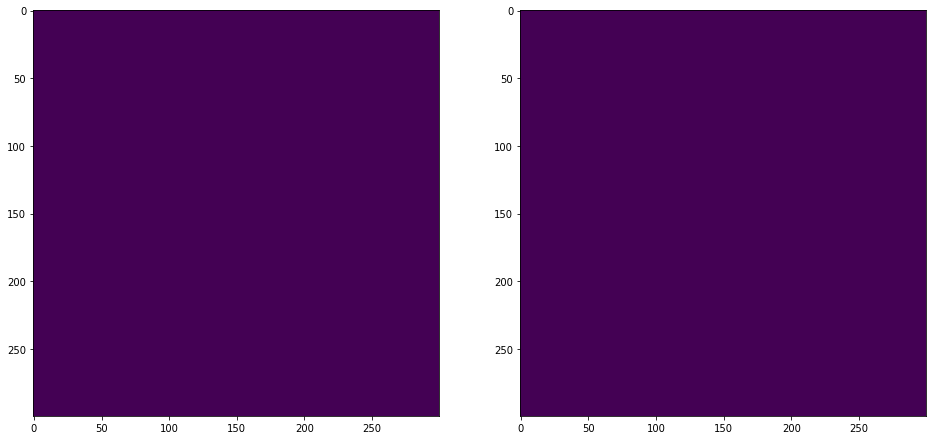

In [20]:
with open(pickle_name,"rb") as f:
    save = pickle.load(f)
    training_features = save['features']
    training_labels = save['labels']
print("Shape of feaures: {}".format(training_features.shape))
print("Shape of labels: {}".format(training_labels.shape))
#Make sure images look okay 
sample_num = 450
angle = 0
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(np.flipud(training_features[sample_num,:,:,angle].transpose()), cmap = 'viridis')
ax.imshow(training_features[sample_num,:,:,angle], cmap = 'viridis')

In [24]:
#Divide the data into train, test 
from sklearn.model_selection import train_test_split
training_features_rs = np.reshape(training_features,(training_features.shape[0],
                                             training_features.shape[1]*training_features.shape[2]*training_features.shape[3]))
X_train,X_test,y_train,y_test = train_test_split(training_features_rs,training_labels,random_state=0,train_size=0.80)
del training_features_rs

/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's train a randm forest classifier to get an estimate of the baseline performance we can achieve with a subset of the data, and the learning rate. 

In [54]:
from sklearn.ensemble import RandomForestClassifier
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
import sklearn.learning_curve as curves
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer,log_loss


def ModelLearningLog(X, y,regressor,train_sizes):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 0)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))
    
    #Create log-loss scorer
    ll_scorer = make_scorer(log_loss)
    
    # Calculate the training and testing scores
    sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
        cv = cv, train_sizes = train_sizes,scoring=ll_scorer)

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve 
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    #ax.set_title('max_depth = %s'%(depth))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    #ax.set_xlim([0, X.shape[0]*0.8])
    #ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
def ModelLearningAvg(X, y,regressor,train_sizes):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 5, test_size = 0.20, random_state = 0)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))
    
    #Create log-loss scorer
    #ll_scorer = make_scorer(log_loss)
    
    # Calculate the training and testing scores
    sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
        cv = cv, train_sizes = train_sizes)

    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Subplot the learning curve 
    ax = fig.add_subplot(1,1,1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Labels
    #ax.set_title('max_depth = %s'%(depth))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    #ax.set_xlim([0, X.shape[0]*0.8])
    #ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [ ]:
clf = RandomForestClassifier()   
train_sizes = [0.10,0.20,0.60,1]
ModelLearning(training_features_rs,training_labels[:,0],clf,train_sizes)

In [6]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier()
clf.fit(X_train,y_train[:,0])
print("Train Score:{}".format(clf.score(X_train,y_train[:,0])))
print("Test score:{}".format(clf.score(X_test,y_test[:,0])))

Train Score:0.9748743718592965
Test score:0.93


Let's work on reducing some of the noise.  The noise appears in the visualization as a "cloud" of points around the silhouette of the subject. 

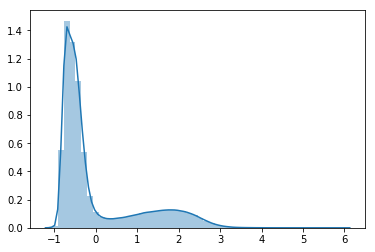

In [12]:
sns.distplot(training_features_rs[np.array([1,10,300]),:].flatten())

Most of the pixels are part of the background.  There is no need to capture the variation in signal from these pixels.  We can eliminate this variation by re-normalizing the data such that any pixel below 0 is forced to be 0.  

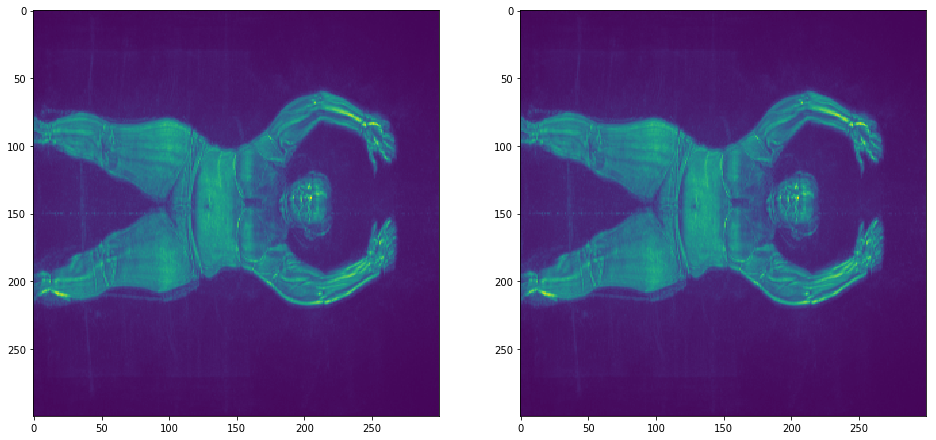

In [15]:
#First, let's make sure we are reshaping the data correctly.
before = training_features[10,:,:,0].copy()
before_flat = before.flatten()
after = np.reshape(before_flat,(before.shape[0],
                                          before.shape[1]))

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(before, cmap = 'viridis')
ax.imshow(after, cmap = 'viridis')


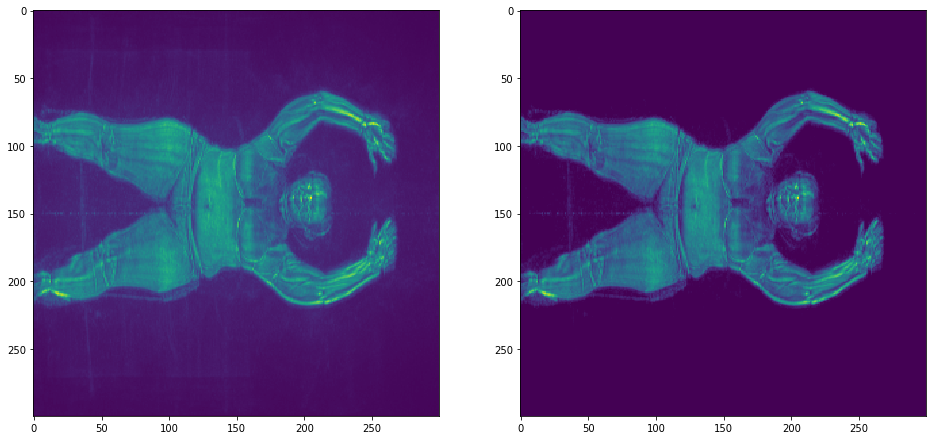

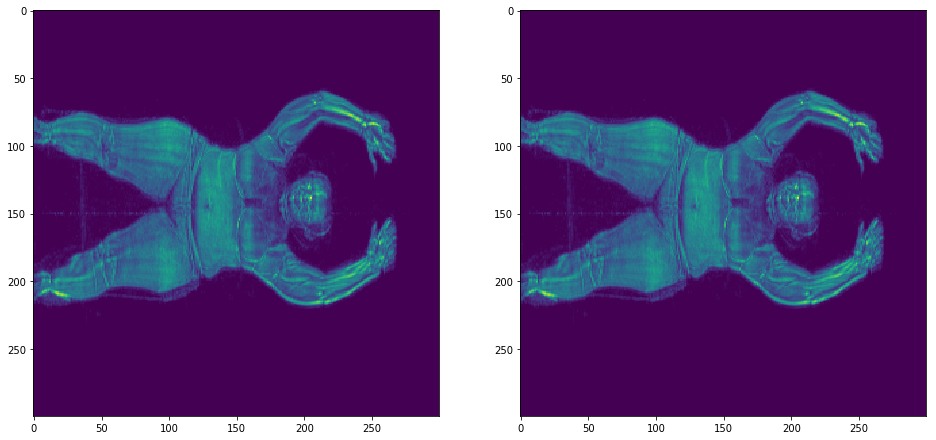

In [21]:
#Any pixel below zero is converted to 0. Then the data is re-normalized. 
def ReduceNoise(x):
    if x < -0.25:
        x = -0.25
    return x
ReduceNoise_v = np.vectorize(ReduceNoise)
after = ReduceNoise_v(before)

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.imshow(before, cmap = 'viridis')
ax2.imshow(after, cmap = 'viridis')

#Normalize image
def NormalizeImage(x):
    img_average = np.mean(x)
    img_std = np.std(x)
    img_norm = (x-img_average)/img_std
    #Resize
    return img_norm
before = after
after = NormalizeImage(before)

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.imshow(before, cmap = 'viridis')
ax2.imshow(after, cmap = 'viridis')

In [22]:
#Now, let's apply these duntions to the entire dataset and plot the distribution again.
#We want to normalize over the entire dataset, so that we may be able to handle duds, or samples with no subject in them.
def NormalizeImage(x,average,std):
    return (x-average)/std
def ExtractNormParameters(x):
    mask = x > -0.25
    average = np.average(x,weights = mask)
    std = x[mask].std()
    return average,std
def ReduceNoise(x):
    if x < -0.25:
        x = -0.25
    return x
ReduceNoise_v = np.vectorize(ReduceNoise)

average, std = ExtractNormParameters(training_features)
for s in range(training_features.shape[0]):
    for a in  range(training_features.shape[3]):
        training_features[s,:,:,a] = ReduceNoise_v(training_features[s,:,:,a])
        training_features[s,:,:,a] = NormalizeImage(training_features[s,:,:,a],average,std)



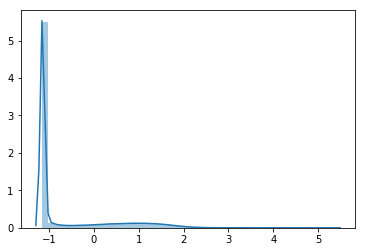

In [23]:
sns.distplot(training_features[np.array([1,10,300]),:,:,:].flatten())

In [10]:
#Encountering some invalid division error
for s in range(training_features.shape[0]):
    for a in  range(training_features.shape[3]):
        if not np.isfinite(training_features[s,:,:,a]).all():
            print("Sample {}, Angle {} contains non-finite values.".format(s,a))          
        

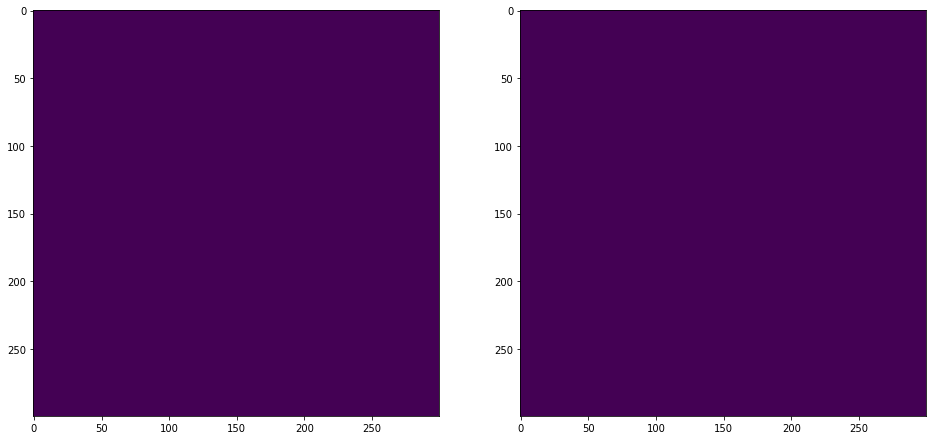

In [11]:
#Plot to make sure that the data is still ok.
sample_num = 443
angle = 0
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.imshow(np.flipud(training_features[sample_num,:,:,angle].transpose()), cmap = 'viridis')
ax.imshow(training_features[sample_num,:,:,angle], cmap = 'viridis')

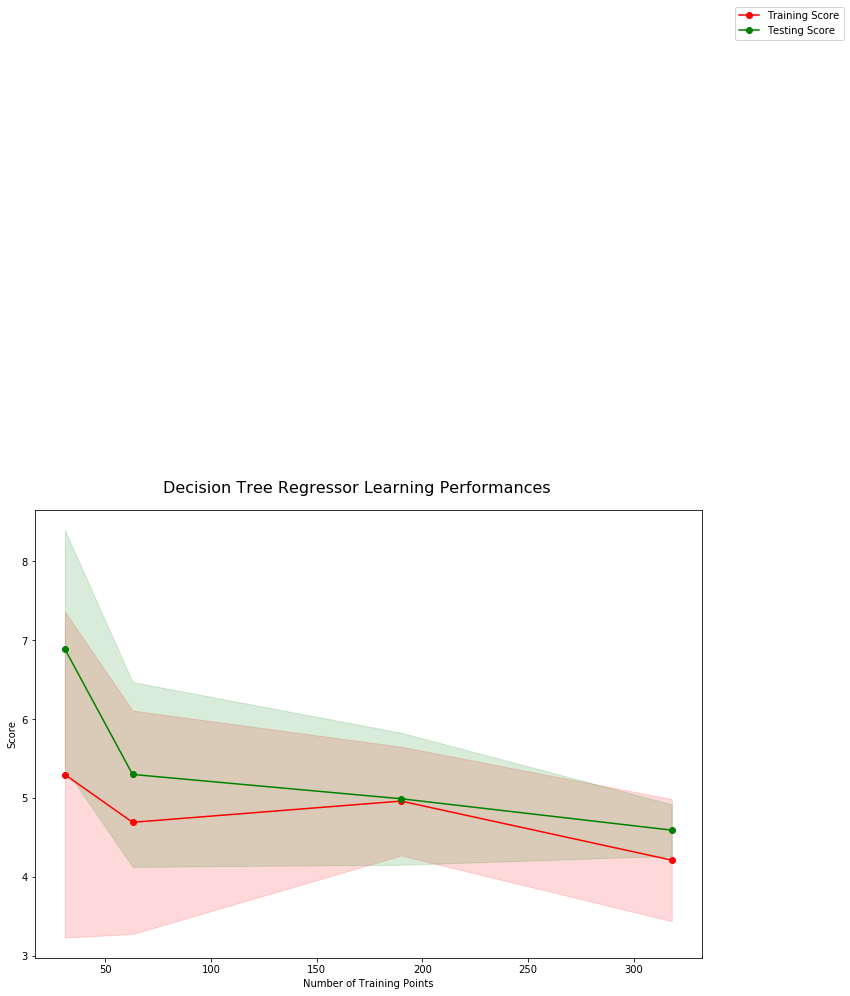

In [26]:
#Let's run on algorithm again, see if there is any improvement.
clf = RandomForestClassifier()   
train_sizes = [0.10,0.20,0.60,1]
ModelLearning(X_train,y_train,clf,train_sizes)

Now, let's work on some dimensionality reduction techniques and see if the accuracy improves.

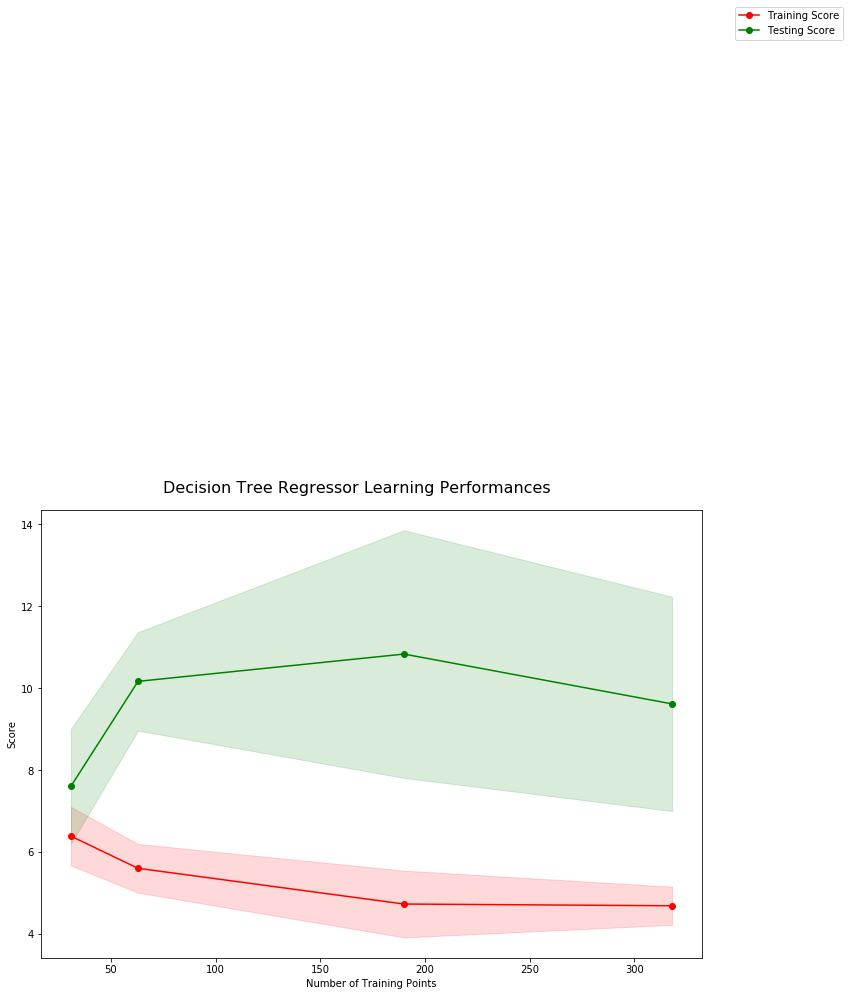

In [32]:
#Try PCA and then run random forest
from sklearn.decomposition import PCA

pca = PCA(25)
X_train_decom = pca.fit_transform(X_train)

clf = RandomForestClassifier()   
train_sizes = [0.10,0.20,0.60,1]
ModelLearning(X_train_decom,y_train,clf,train_sizes)



In [31]:
print(pca.explained_variance_ratio_)

[ 0.23203298  0.10373372  0.07282058  0.05304965  0.02697826  0.02513715
  0.01945005  0.01642394  0.01559427  0.013176    0.01267154  0.01172326
  0.01101162  0.01029441  0.00963173  0.00797107  0.00777233  0.00716538
  0.00694811  0.00663357  0.00624363  0.00599159  0.0057287   0.00499272
  0.00492463]


In [73]:
#With whitening
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca = PCA(10000,whiten=True)
X_train_decom = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_[1:10])

clf = RandomForestClassifier()   
train_sizes = [0.10,0.20,0.60,1]
print(X_train_decom.shape)

ModelLearningLog(X_train_decom,y_train,clf,train_sizes)
ModelLearningAvg(X_train_decom,y_train[:,0],clf,train_sizes)

clf2 = LogisticRegression()
ModelLearningAvg(X_train_decom,y_train[:,0],clf,train_sizes)


NameError: name 'clf' is not defined

Not very successful.  Let's try ICA.

from sklearn.decomposition import FastICA

#ica = FastICA(3,whiten=False,max_iter = 1000)
#X_train_decom = ica.fit_transform(X_train)

#clf = RandomForestClassifier()   
#train_sizes = [0.10,0.20,0.60,1]
#ModelLearning(X_train_decom,y_train,clf,train_sizes)

#ICA not working for some reason. 